# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import pandas as pd

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
x_train, y_train = train['X'], train['y']
x_test, y_test = test['X'], test['y']
print("Training Set", x_train.shape, y_train.shape)
print("Test Set", x_test.shape, y_test.shape)
x_train, y_train = x_train.transpose((3,0,1,2)), y_train[:,0]
x_test, y_test = x_test.transpose((3,0,1,2)), y_test[:,0]
print("Training Set", x_train.shape, y_train.shape)
print("Test Set", x_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)
Training Set (73257, 32, 32, 3) (73257,)
Test Set (26032, 32, 32, 3) (26032,)


In [4]:
def plot_images(img, labels):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(2, 5)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

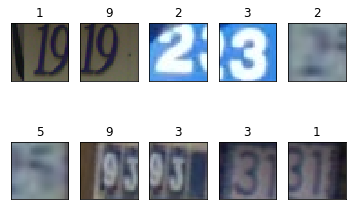

In [5]:
plot_images(x_train, y_train)

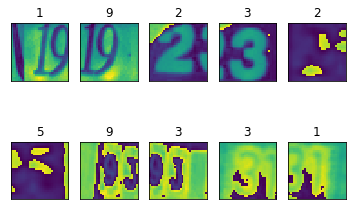

In [6]:
x_train = tf.image.rgb_to_grayscale(x_train)
x_test = tf.image.rgb_to_grayscale(x_test)
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train = (x_train - train_mean) / train_std
x_test = (x_test - train_mean) / train_std
y_test_same = y_test
plot_images(x_train, y_train)

enc = OneHotEncoder().fit(y_train.reshape(-1, 1))
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [7]:
def get_model(input_shape):
    model = Sequential([
        BatchNormalization(input_shape=input_shape),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

In [8]:
model = get_model(x_train[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 1)         4         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 132,494
Trainable params: 132,492
Non-trainable params: 2
_________________________________________________________________


In [9]:
epoch_checkpoint_mlp = ModelCheckpoint(filepath = 'mlp_checkpoints_every_epoch/checkpoint_.{epoch:03d}', 
                           frequency = 'epoch',
                          save_weights_only=True)

best_checkpoint_mlp = ModelCheckpoint(filepath = 'mlp_checkpoints_best_only/checkpoint',
                           save_best_only= True, save_weights_only = True,
                          monitor = 'val_accuracy') 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=16, validation_split = 0.20, 
                    callbacks=[epoch_checkpoint_mlp, best_checkpoint_mlp])


Train on 58605 samples, validate on 14652 samples
Epoch 1/16
58605/58605 [==============================] - 55s 934us/sample - loss: 1.6808 - acc: 0.4481 - val_loss: 1.4436 - val_acc: 0.5341
Epoch 2/16
58605/58605 [==============================] - 48s 825us/sample - loss: 1.3250 - acc: 0.5754 - val_loss: 1.3761 - val_acc: 0.5517
Epoch 3/16
58605/58605 [==============================] - 47s 801us/sample - loss: 1.1866 - acc: 0.6230 - val_loss: 1.3156 - val_acc: 0.5838
Epoch 4/16
58605/58605 [==============================] - 46s 790us/sample - loss: 1.0902 - acc: 0.6550 - val_loss: 1.2661 - val_acc: 0.6111
Epoch 5/16
58605/58605 [==============================] - 46s 789us/sample - loss: 1.0203 - acc: 0.6798 - val_loss: 1.2947 - val_acc: 0.6089
Epoch 6/16
58605/58605 [==============================] - 48s 816us/sample - loss: 0.9564 - acc: 0.7010 - val_loss: 1.2687 - val_acc: 0.6203
Epoch 7/16
58605/58605 [==============================] - 46s 788us/sample - loss: 0.9049 - acc: 0.7148 

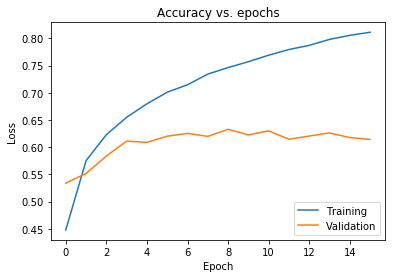

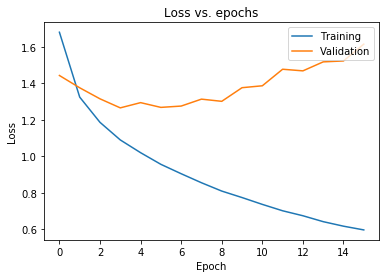

In [10]:

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


In [11]:
model.evaluate(x_test, y_test, verbose = 2)

26032/1 - 5s - loss: 1.3877 - acc: 0.6198


[1.6442967105952229, 0.6198141]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [12]:
def cnn_get_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4), 
        Dense(10,  activation='softmax')
    ])
    return model

In [13]:
model = cnn_get_model(x_train[0].shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)       

In [ ]:
epoch_checkpoint = ModelCheckpoint(filepath = 'checkpoints_every_epoch/checkpoint_.{epoch:03d}', 
                           frequency = 'epoch',
                          save_weights_only=True)

best_checkpoint = ModelCheckpoint(filepath = 'checkpoints_best_only/checkpoint',
                           save_best_only= True, save_weights_only = True,
                          monitor = 'val_accuracy') 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=16, batch_size = 128, validation_split = 0.3,
                    callbacks=[epoch_checkpoint, best_checkpoint])

Train on 51279 samples, validate on 21978 samples
Epoch 1/16
51279/51279 [==============================] - 1684s 33ms/sample - loss: 2.2355 - acc: 0.1863 - val_loss: 2.1183 - val_acc: 0.2745
Epoch 2/16
51279/51279 [==============================] - 1675s 33ms/sample - loss: 2.0208 - acc: 0.2627 - val_loss: 1.4812 - val_acc: 0.4920
Epoch 3/16
51279/51279 [==============================] - 1684s 33ms/sample - loss: 1.4351 - acc: 0.4831 - val_loss: 0.7987 - val_acc: 0.7396
Epoch 4/16
51279/51279 [==============================] - 1696s 33ms/sample - loss: 0.8253 - acc: 0.7372 - val_loss: 0.5473 - val_acc: 0.8301
Epoch 5/16
51279/51279 [==============================] - 1654s 32ms/sample - loss: 0.5824 - acc: 0.8254 - val_loss: 0.4303 - val_acc: 0.8691
Epoch 6/16
26624/51279 [==============>...............] - ETA: 12:08 - loss: 0.4954 - acc: 0.8532

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


In [ ]:
model.evaluate(x_test, y_test, verbose = 2)


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
mlp = tf.train.latest_checkpoint("mlp_checkpoints_every_epoch")
mlp_model = get_model(x_test[0].shape)
mlp_model.load_weights(mlp)

cnn = tf.train.latest_checkpoint("checkpoints_every_epoch")
cnn_model = cnn_get_model(x_test[0].shape)
cnn_model.load_weights(cnn)

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from pylab import *

img0 = x_test[0,:,:,0] #Image 1
img1 = x_test[1,:,:,0] #Image 2
img2 = x_test[2,:,:,0] #Image 3
img3 = x_test[3,:,:,0] #Image 4
img4 = x_test[4,:,:,0] #Image 5

def plot_image(image, label):
    plt.imshow(np.squeeze(image))
    plt.axis("off")
    if label == 10:
        plt.title("Actual: 0")
    else:
        plt.title(f"Actual: {label}")

def plot_prediction(y_pred_MLP, modelname):
    x_pos = range(10)
    y_pos = np.squeeze(y_pred_MLP)
    plt.bar(x_pos, y_pos)
    plt.ylim([0, 1])
    plt.xticks(x_pos)
    if np.squeeze(y_pred_MLP).argmax() + 1 == 10:
        plt.title(f"{modelname} predicted 0")
    else:
        plt.title(f"{modelname} predicted {np.squeeze(y_pred_MLP).argmax() + 1}")
    plt.xlabel("output unit")
    plt.ylabel("output value")

In [ ]:
def fun(image, test, label):
    fig = plt.figure(figsize=(14, 3))
    fig.add_subplot(1, 3, 1)
    plot_image(image, label)
    fig.add_subplot(1, 3, 2)
    y_pred_MLP = mlp_model.predict(np.expand_dims(test, axis=0))
    plot_prediction(y_pred_MLP, modelname='MLP')
    fig.add_subplot(1, 3, 3)
    y_pred_CNN = cnn_model.predict(np.expand_dims(test, axis=0))
    plot_prediction(y_pred_CNN, modelname='CNN')
    plt.show()
  
fun(img0, x_test[0], y_test_same[0])

In [ ]:
fun(img1, x_test[1], y_test_same[1])

In [ ]:
fun(img2, x_test[2], y_test_same[2])

In [ ]:
fun(img3, x_test[3], y_test_same[3])

In [ ]:
fun(img4, x_test[4], y_test_same[4])